### Table of Contents

* [Perceptron - sklearn](#Perceptron)
* [Tensorflow & Keras](#tensorflow_keras)
    * [Tensors](#tensors)
    * [Derivative computation](#tensors_derivatives)
* [Neural networks](#neural_networks)
    * [Layers in Keras](#keras_layers)
    * [Sequential Model - classification MLP](#sequential_api)
    * [Sequential Model - Regression MLP](#sequential_regression_mlp)
    * [Functional Model - Regression MLP](#functional_regression_mlp)
    * [Save & Load a model](#save_and_load)
    * [Callbacks & Tensorboard](#callbacks_and_tb)
    * [Multi input model](#multi_input_model)
    * [Multi input & output model](#multi_input_output_model)
    * [Subclassing API Wide & Deep](#subclass_api)
    * [Hyperparameters Search](#hyperparam_search)
    * [Batch Normalization](#batch_normalization)
    * [Gradient Clipping](#grad_clipping)
    * [transfer_learning](#transfer_learning)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# inline plot 
%matplotlib inline  
# default figure size 
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible 

## Perceptron (sklearn)  <a class="anchor" id="Perceptron"></a>

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [7]:
y_pred

array([1])

# Tensorflow & Keras  <a class="anchor" id="tensorflow_keras"></a>

In [ ]:
# !pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow import keras


## Tensors & Variables  <a class="anchor" id="tensors"></a>
A tensor is the data flowing through the network 
Tensors are multi-dimensional arrays with a uniform type (like float/int/bool)


tf.constant generates a constant tensor which is immutable and cant be changed once defined

In [6]:
# using numpy array
a = tf.constant(np.array([2., 4., 5.]))
# using nested lists
u = tf.constant([[1],[2],[3]], dtype=tf.float32)
u.shape

TensorShape([3, 1])

In [10]:
u.shape

TensorShape([3, 1])

In [11]:
tf.constant([1, 2, 3, 4, 5, 6], shape=[2, 3])

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]])>

A variable is a special tensor which is mutable and can be updated during training 

In [8]:
V = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

# assignment
V.assign(2 * V) # => [[2., 4., 6.], [8., 10., 12.]]
V[0, 1].assign(42) # => [[2., 42., 6.], [8., 10., 12.]]
V[:, 2].assign([0., 1.]) # => [[2., 42., 0.], [8., 10., 1.]]
# indices is a list of entries specifications 
V.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.]) # => [[100., 42., 0.], [8., 10., 200.]]

# same as above using dtype for casting the values to float
V = tf.Variable([[1, 2, 3],[4, 5, 6]], shape=[2, 3], dtype=tf.float32)
V

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

tensorflow provides various operations to manipulate tensors using which the neural network is implemented

In [11]:
# Vu
x = tf.matmul(V, u, transpose_b=False)

# typing matters: this want work cant add int with float
# tf.constant(2.) + tf.constant(40)
tf.constant(2.) * tf.cast(tf.constant(40), tf.float32)


<tf.Tensor: shape=(), dtype=float32, numpy=80.0>

## Derivative computation <a class="anchor" id="tensors_derivatives"></a>

In [23]:
# to make the result reproducible 
tf.random.set_seed(10)

# the weights
W = tf.Variable(tf.random.normal((3, 2)), name='W')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]
y_true = [[5., 6.]]

# tf.GradientTape context will automatically record every operation that involves a variable, and finally we
# ask this tape to compute the gradients of the result loss with regards to both variables W and b

# The tape is automatically erased immediately after you call its gradient() method, so
# you will get an exception if you try to call gradient() twice, using persistent=True overrides this 
# and allows us to call gradient() multiple times
with tf.GradientTape(persistent=True) as tape:
    z = x @ W + b # the same as  y = tf.matmul(x, W) + b
    y = tf.sigmoid(z) # no really need for a sigmoid here, just for demonstration 
    loss = tf.reduce_mean((y_true - y)**2)

[dloss_dW, dloss_db] = tape.gradient(loss, [W, b])
[dloss_dW, dloss_db]

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-0.6342581, -0.3191079],
        [-1.2685162, -0.6382158],
        [-1.9027743, -0.9573237]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.6342581, -0.3191079], dtype=float32)>]

# Neural Networks  <a class="anchor" id="neural_networks"></a>

In [17]:
fashion_mnist = keras.datasets.fashion_mnist

class_names = [
    "T-shirt/top", 
    "Trouser", 
    "Pullover", 
    "Dress", 
    "Coat",
    "Sandal", 
    "Shirt", 
    "Sneaker", 
    "Bag", 
    "Ankle boot"
]

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(f'''
number of samples in train: {X_train_full.shape[0]}
number of features: {X_train_full.shape}
''')


number of samples in train: 60000
number of features: (60000, 28, 28)



In [18]:
# Scale features to be in the unit range [0,1]
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# don't forget scaling test too!!!
X_test = X_test / 255.


In [12]:
X_train[0].shape

(28, 28)

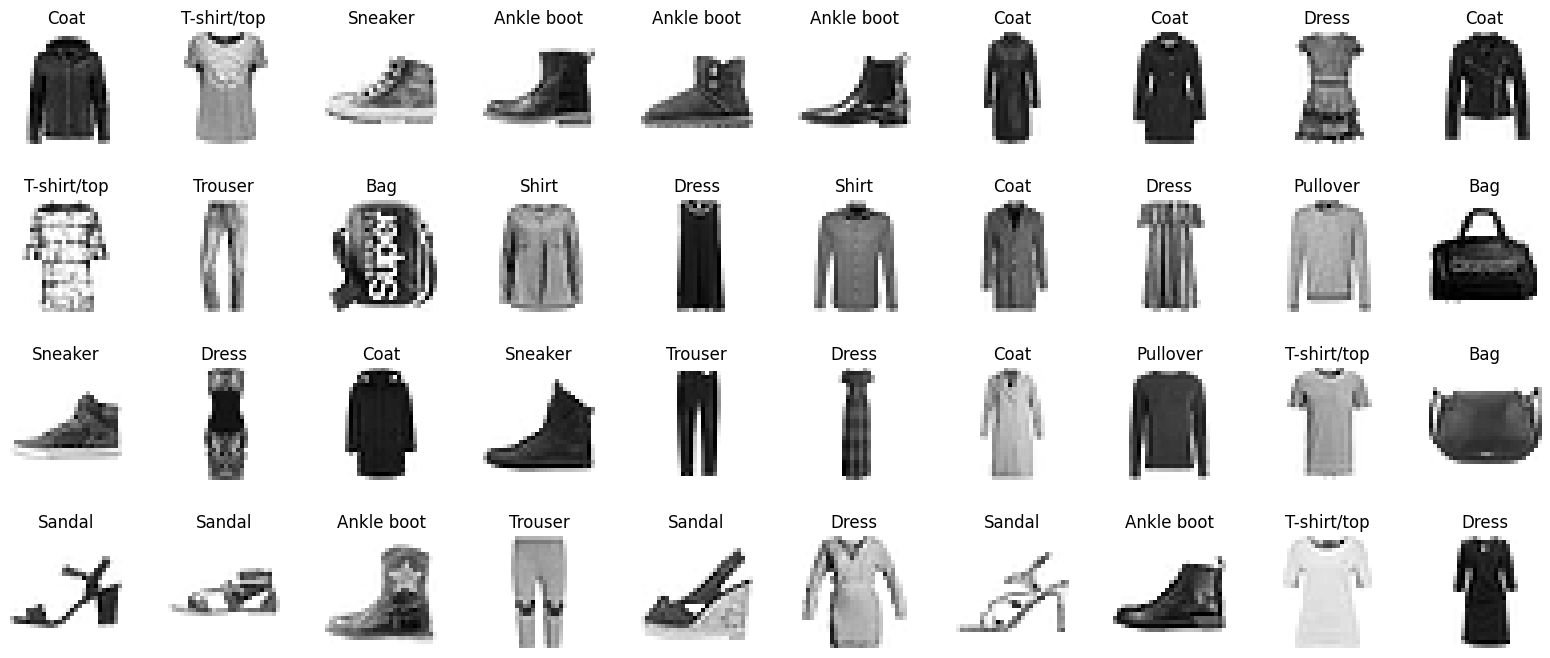

In [6]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Layers in Keras  <a class="anchor" id="keras_layers"></a>

### Dense Layer

In [7]:
# units - the number of neurons in the layer 
# the number of input units is either determined in runtime (first call) or by declaring input size (see below)
dense_layer = keras.layers.Dense(units=4, 
                                 activation='sigmoid', 
                                 use_bias=True, 
                                 kernel_initializer='glorot_normal', 
                                 name='my_dense_layer')

input_batch = tf.constant([[1.,2.,3.],[0.,1.,2.]])

# input 2x3, W 3x4
dense_layer(input_batch)


<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.9887459 , 0.28738657, 0.90897745, 0.58294314],
       [0.94907075, 0.4243562 , 0.8038137 , 0.61151385]], dtype=float32)>

In [15]:
# this will raise an error
different_input_batch = tf.constant([[1.,2.],[0.,1.]])
dense_layer(different_input_batch)


ValueError: Input 0 of layer "my_dense_layer" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (2, 2)

In [16]:
# get the weights :  #input neurons x #units   and the bias weights: # units
# notece that these are Variables 
dense_layer.weights

[<KerasVariable shape=(3, 4), dtype=float32, path=my_dense_layer/kernel>,
 <KerasVariable shape=(4,), dtype=float32, path=my_dense_layer/bias>]

### Embedding layer
Transforms a categorical variable to a vector.

Equivalent to transforming the index to a one-hot vector and then multiplying by an embedding matrix 

[The, dog, eats] -> [2, 30, 15] -> Embedding layer -> vectors

In [17]:
# input dim is the vocabulary size: vocabulary size is taken to be 100
# vector size is 4 (embedding size)

indexed_values = tf.constant([[1,2,3],[0,1,2]])
# input_dim is vocab size + 1
# Embedding works on every index independently
embedding_layer = keras.layers.Embedding(input_dim=100, output_dim=4, mask_zero=True)
embedding_layer(indexed_values)

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 0.02315103,  0.01101724,  0.04194787, -0.02394526],
        [-0.01869446,  0.03570301,  0.02464462,  0.01654721],
        [-0.02305965,  0.02008564, -0.04808381,  0.03896786]],

       [[-0.02144891, -0.00397273, -0.01235715,  0.04076197],
        [ 0.02315103,  0.01101724,  0.04194787, -0.02394526],
        [-0.01869446,  0.03570301,  0.02464462,  0.01654721]]],
      dtype=float32)>

In [18]:
embedding_layer(indexed_values).shape

TensorShape([2, 3, 4])

In [19]:
# calculates the vectors to be discarded
embedding_layer.compute_mask(indexed_values)

<tf.Tensor: shape=(2, 3), dtype=bool, numpy=
array([[ True,  True,  True],
       [False,  True,  True]])>

## Sequential Model - Classification <a class="anchor" id="sequential_api"></a>

In [19]:
# Resets all state generated by Keras. (responsible for managing layer names etc.)

# Creating multiple models within the same script or notebook session without clearing the session 
# can lead to increased memory usage. 
# This happens because TensorFlow/Keras retains the computational graphs and layers of all the models created. 
# Clearing the session helps free up memory used by these graphs and layers.

keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)


# sequential API
model = keras.models.Sequential()
# flattens tensor shape (28,28) to (784,)
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", name='my_hidden'))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# Equivalent 
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(10, activation="softmax")
# ])

In [21]:
# show the layers of the model
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=my_hidden, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_hidden (Dense)                    │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# %pip install pydot

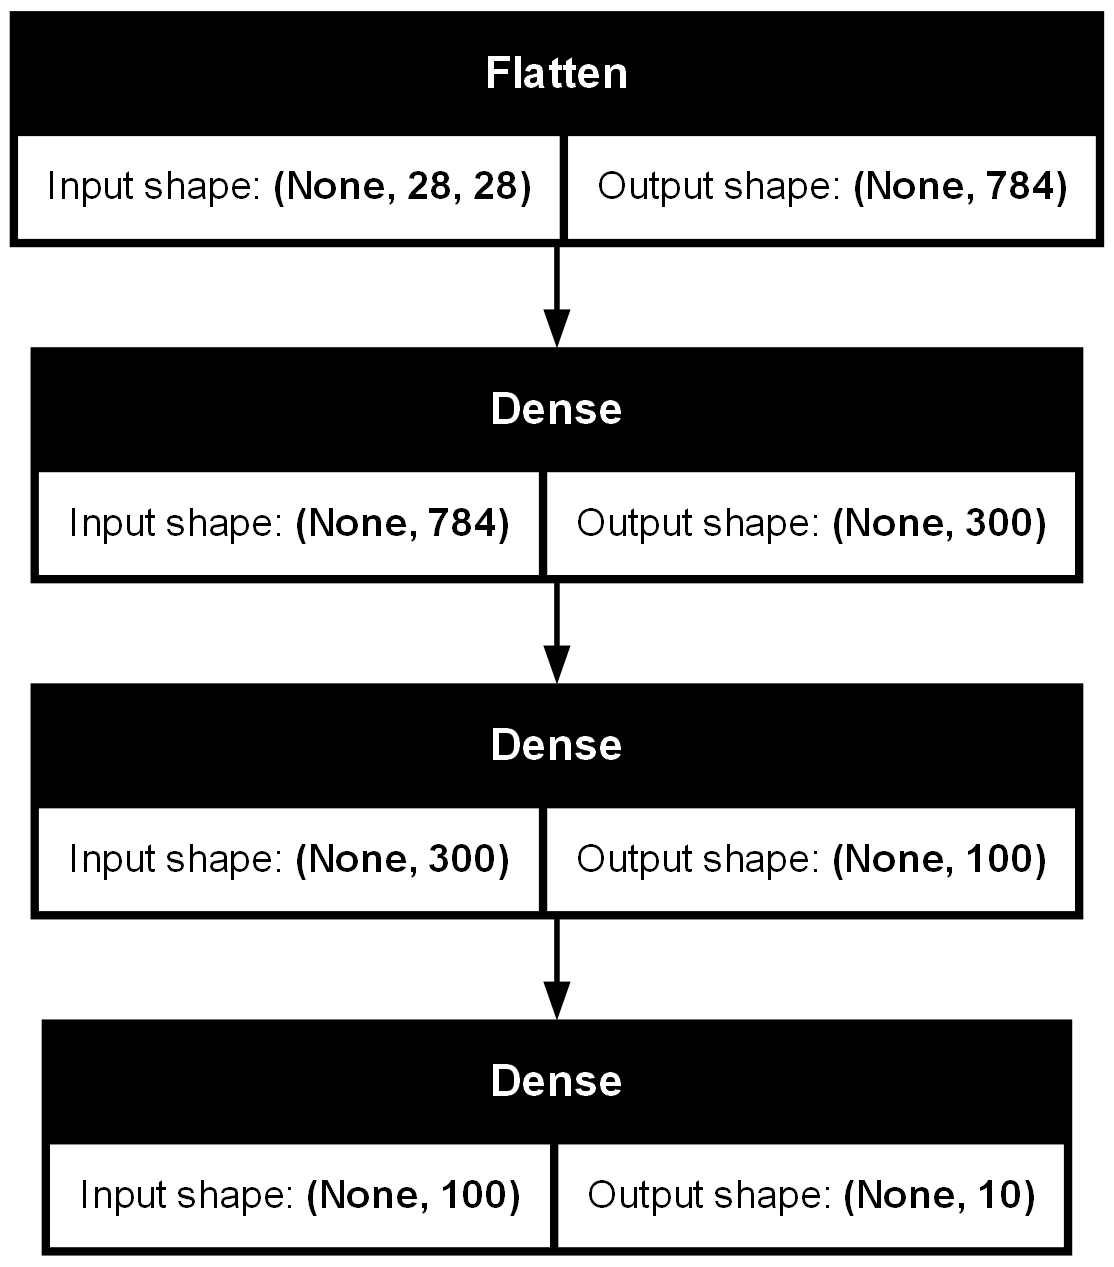

In [10]:
keras.utils.plot_model(model, show_shapes=True)

In [11]:
# get the first hidden layer
hidden1 = model.layers[1]
# its name
layer_name = hidden1.name
# can access a layer by name
hidden1 = model.get_layer('my_hidden')

# get the layer weights
weights, biases = hidden1.get_weights()

print(f'''
hidden layer 1 name: {layer_name}
weights shape: {weights.shape}
bias shape: {biases.shape}
''')


hidden layer 1 name: my_hidden
weights shape: (784, 300)
bias shape: (300,)



Compilation - binds a loss and an optimizer to the model

In [20]:
# compile the model - Configures the model for training.
# categorical crossentropy in the exact same loss as softmax classification model
# metrics: List of metrics to be evaluated by the model during training and testing.

# "sparse_categorical_crossentropy" is used when the labels are provided as indices 
# rather than one-hot encoded vectors

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# equivalent
# model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#               optimizer=keras.optimizers.SGD(),
#               metrics=[keras.metrics.sparse_categorical_accuracy])

In [21]:
# Note: we can also provide validation data 
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6891 - loss: 0.9919 - val_accuracy: 0.8200 - val_loss: 0.5186
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8222 - loss: 0.5004 - val_accuracy: 0.8440 - val_loss: 0.4580
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8417 - loss: 0.4501 - val_accuracy: 0.8532 - val_loss: 0.4279
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8522 - loss: 0.4204 - val_accuracy: 0.8608 - val_loss: 0.4061
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8592 - loss: 0.3989 - val_accuracy: 0.8656 - val_loss: 0.3900
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8642 - loss: 0.3818 - val_accuracy: 0.8686 - val_loss: 0.3766
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8684 - loss: 0.3678 - val_accuracy: 0.8692 - val_loss: 0.3672
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8724 - loss: 0.3559 - 

In [14]:
# show training params like numbber of epochs ran 
history.params

{'verbose': 'auto', 'epochs': 10, 'steps': 1719}

In [15]:
# metrics
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [22]:
pd.DataFrame(history.history).reset_index().rename(columns={'index': 'epoch'})[:5]

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.766236,0.714401,0.8200,0.518592
1,1,0.829145,0.487317,0.8440,0.458042
2,2,0.844218,0.444289,0.8532,0.427886
3,3,0.853855,0.416891,0.8608,0.406116
4,4,0.860509,0.396359,0.8656,0.389971


(0.0, 1.0)

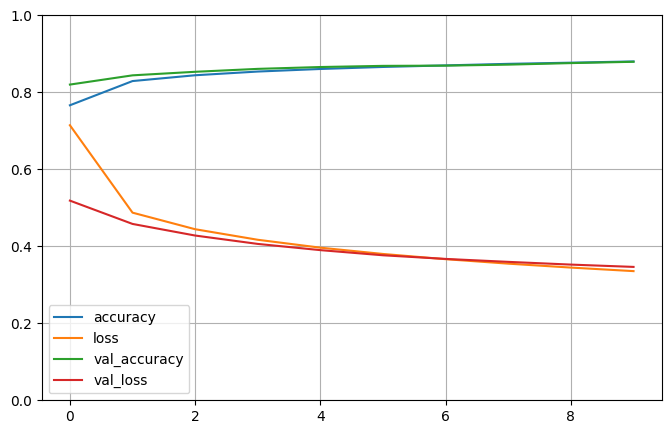

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [24]:
# evaluate on test
# loss and metric results are returned as a dict, with each key being the name of the metric
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8655 - loss: 0.3828


(0.3880611062049866, 0.8618000149726868)

In [25]:
# predict
X_new = X_test[:10]
y_proba = model.predict(X_new)

print(f'''
raw predictions: 
{y_proba.round(2)}
predicted classes 
{np.array(class_names)[np.argmax(model.predict(X_new), axis=-1)]}
''')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

raw predictions: 
[[0.   0.   0.   0.   0.   0.08 0.   0.11 0.01 0.8 ]
 [0.   0.   0.98 0.   0.01 0.   0.01 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.06 0.   0.21 0.01 0.04 0.   0.68 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.02 0.   0.94 0.   0.04 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.14 0.   0.84 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.94 0.   0.04 0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01 0.   0.99 0.   0.  ]]
predicted classes 
['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt' 'Trouser' 'Coat'
 'Shirt' 'Sandal' 'Sneaker']



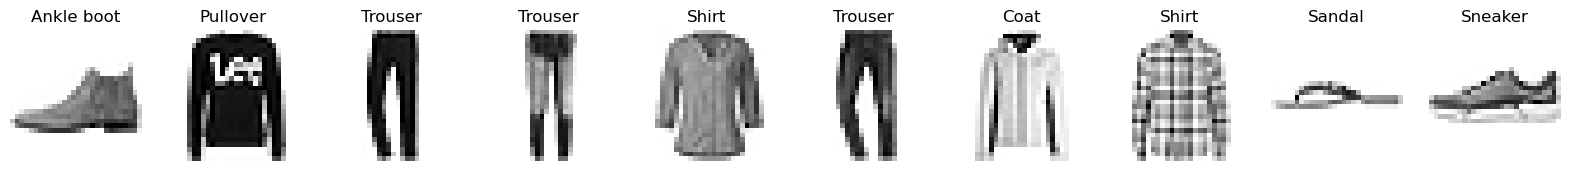

In [20]:
plt.figure(figsize=(20, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, len(X_new), index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)


## Sequential API - Regression MLP  <a class="anchor" id="sequential_regression_mlp"></a>

In [27]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

# information about the data
print(housing['DESCR'])

print('Data table')
print('===========')
print(fetch_california_housing(as_frame=True)['data'].head())

# target/label = MedHouseVal

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# features scaling
scaler = StandardScaler()

# fit only on train
X_train = scaler.fit_transform(X_train)

# transform validation and test
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

# reset the state - all previous variables are deleted from memory
keras.backend.clear_session()

# Define the model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
print(f'MSE on test {mse_test}')

X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3223 - val_loss: 1.0744
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9322 - val_loss: 0.7424
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7914 - val_loss: 0.6710
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7315 - val_loss: 0.6220
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6883 - val_loss: 0.5852
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6523 - val_loss: 0.5549
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6207 - val_loss: 0.5293
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5922 - val_loss: 0.5075
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5671 - val_loss: 0.4890
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5454 - val_loss: 0.4741
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5270 - val_loss: 0.4621
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │             270 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 303 (1.19 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

(0.0, 1.0)

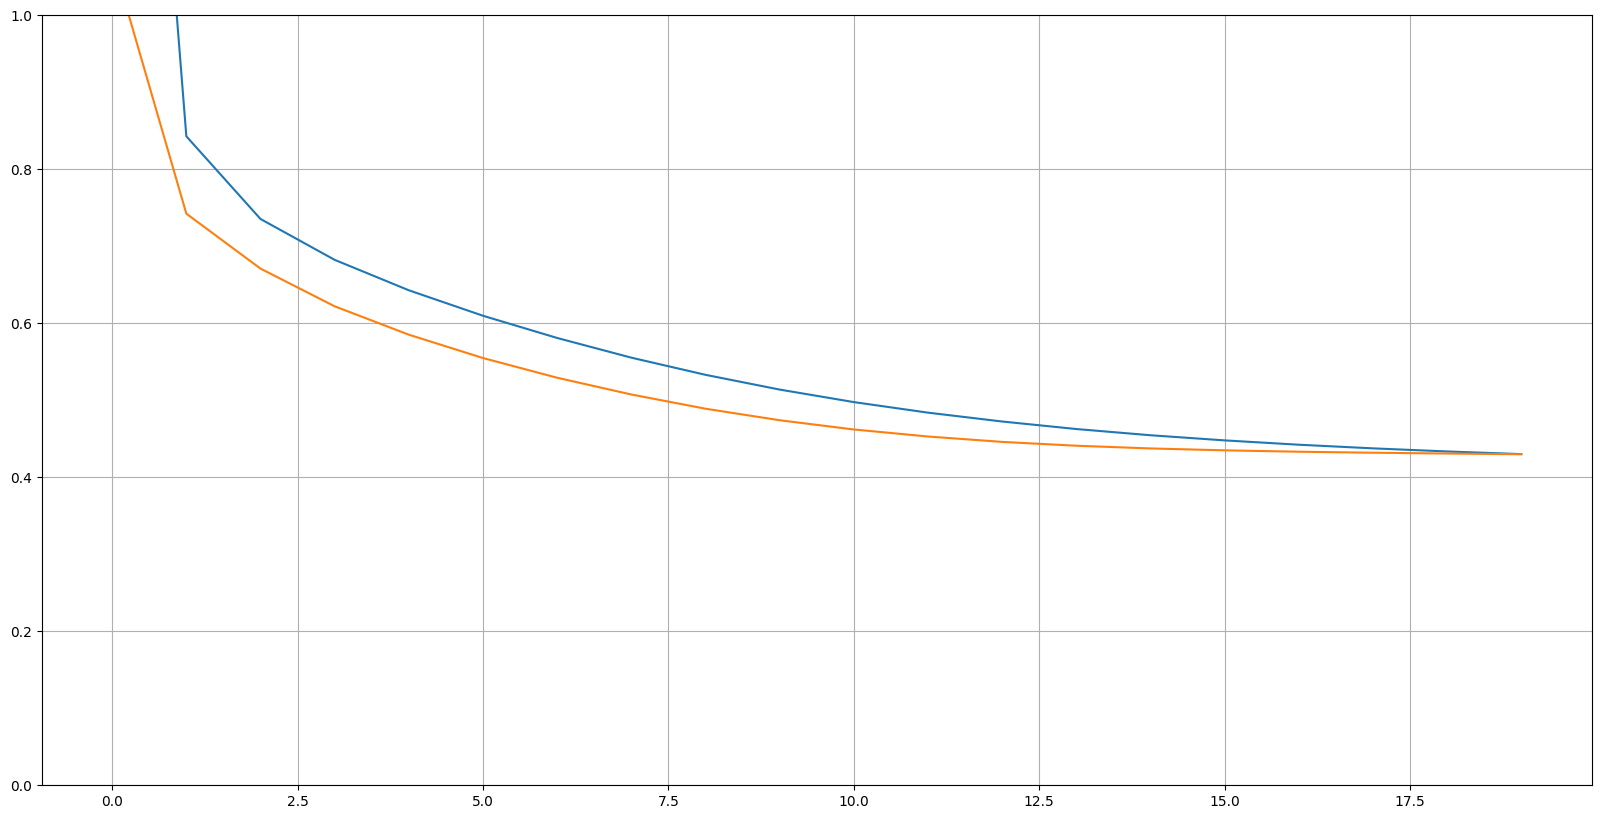

In [17]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)

## Functional API - Regression MLP  <a class="anchor" id="functional_regression_mlp"></a>

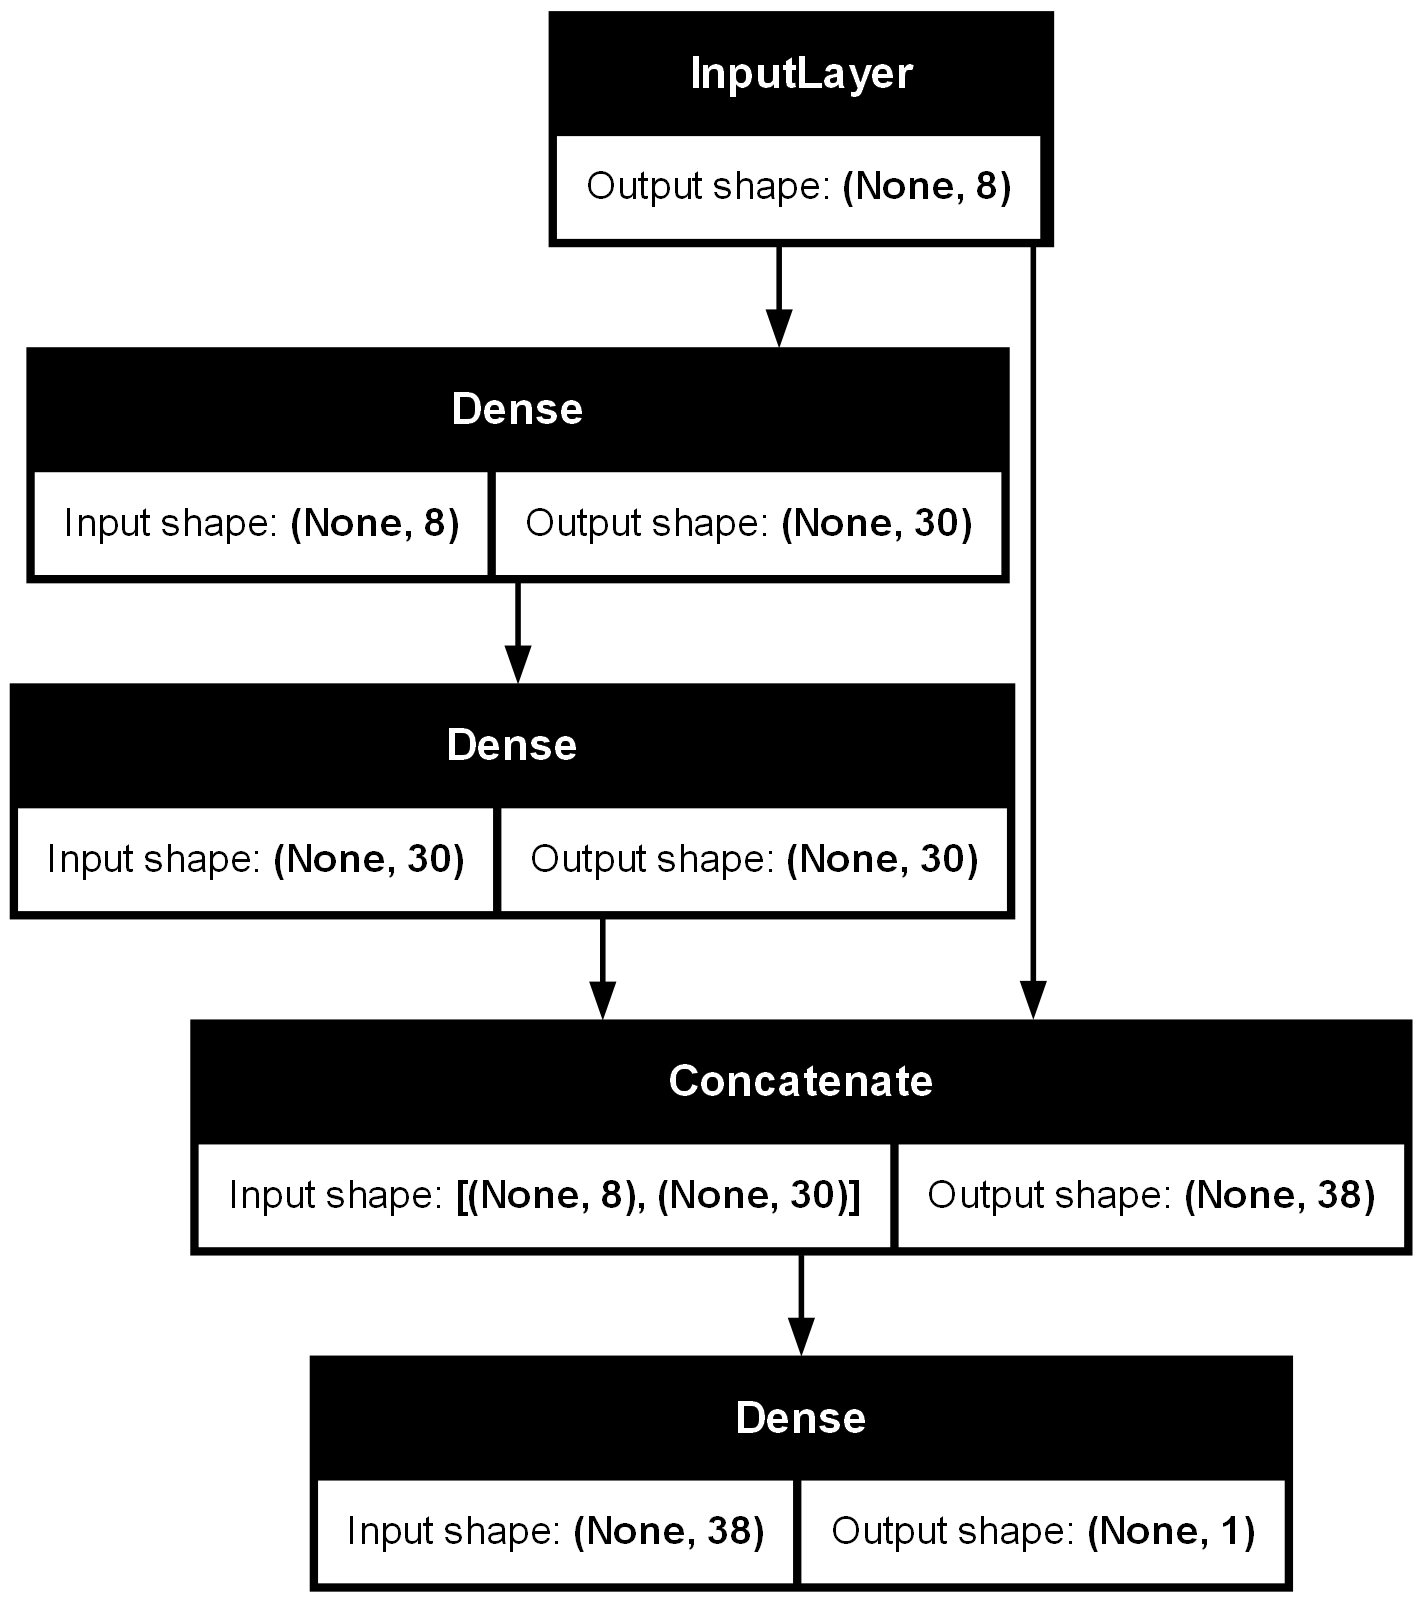

In [19]:
## Functional API
# Allows to define more complex networks 
# The following architecture is called "wide and deep" 
# “Wide & Deep Learning for Recommender Systems,” Heng-Tze Cheng et al. (2016).


np.random.seed(42)
tf.random.set_seed(42)

# Here the input shape is (8,) we are not taking the first dimension (the dataset size)
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
# this layer just concatenates the input_ tensor and hidden2 tensor along the last axis
concat = keras.layers.concatenate([input_, hidden2], axis=-1)
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input_], outputs=[output])

keras.utils.plot_model(model, show_shapes=True)

In [26]:
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
print(f'MSE on test {mse_test}')

y_pred = model.predict(X_new)


Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7934 - val_loss: 3.0722
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7979 - val_loss: 0.6891
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7211 - val_loss: 0.6390
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6796 - val_loss: 0.6058
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6469 - val_loss: 0.5785
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6201 - val_loss: 0.5552
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5976 - val_loss: 0.5352
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5781 - val_loss: 0.5178
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5613 - val_loss: 0.5027
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5467 - val_loss: 0.4891
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5337 - val_loss: 0.4769
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

## Saving and loading <a class="anchor" id="save_and_load"></a>

In [39]:
# save and load model
model.save("my_model.keras", include_optimizer=True)
model = keras.models.load_model("my_model.keras")
y_pred = model.predict(X_new)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [34]:
# only saves the weights the network will need to be defined via code
model.save_weights(".weights.h5")

# define the model here
# ....
# ....
model.load_weights(".weights.h5")



## Using callbacks & Tensorboard <a class="anchor" id="callbacks_and_tb"></a>


In [28]:
# To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

# $ tensorboard --logdir=./my_logs --port=6006
# You can then open your web browser to localhost:6006 and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006


In [40]:
import os


# checkpoint a model. here we save the best model relative to validation loss
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="my_model.keras",     
                                                monitor='val_loss',
                                                save_best_only=True)

# restore_best_weights - Whether to restore model weights from
# the epoch with the best value of the monitored quantity.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# custom callback
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        

root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

history = model.fit(
    X_train, y_train, 
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, 
               early_stopping_cb,
               PrintValTrainRatioCallback(),
               keras.callbacks.TensorBoard(run_logdir)]
)



Epoch 1/10
325/363 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 0.4521
val/train: 0.94
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4497 - val_loss: 0.4064
Epoch 2/10
356/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4446
val/train: 0.94
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4442 - val_loss: 0.4029
Epoch 3/10
348/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4401
val/train: 0.95
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4393 - val_loss: 0.3999
Epoch 4/10
313/363 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.4376
val/train: 0.95
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4347 - val_loss: 0.3971
Epoch 5/10
357/363 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.4307
val/train: 0.95
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4304 - val_loss: 0.3947
Epoch 6/10
354/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4268
val/train: 0.95
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4264 - val_loss: 0.3925
Epoch 7/10
329/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

## Multi Input model <a class="anchor" id="multi_input_model"></a>

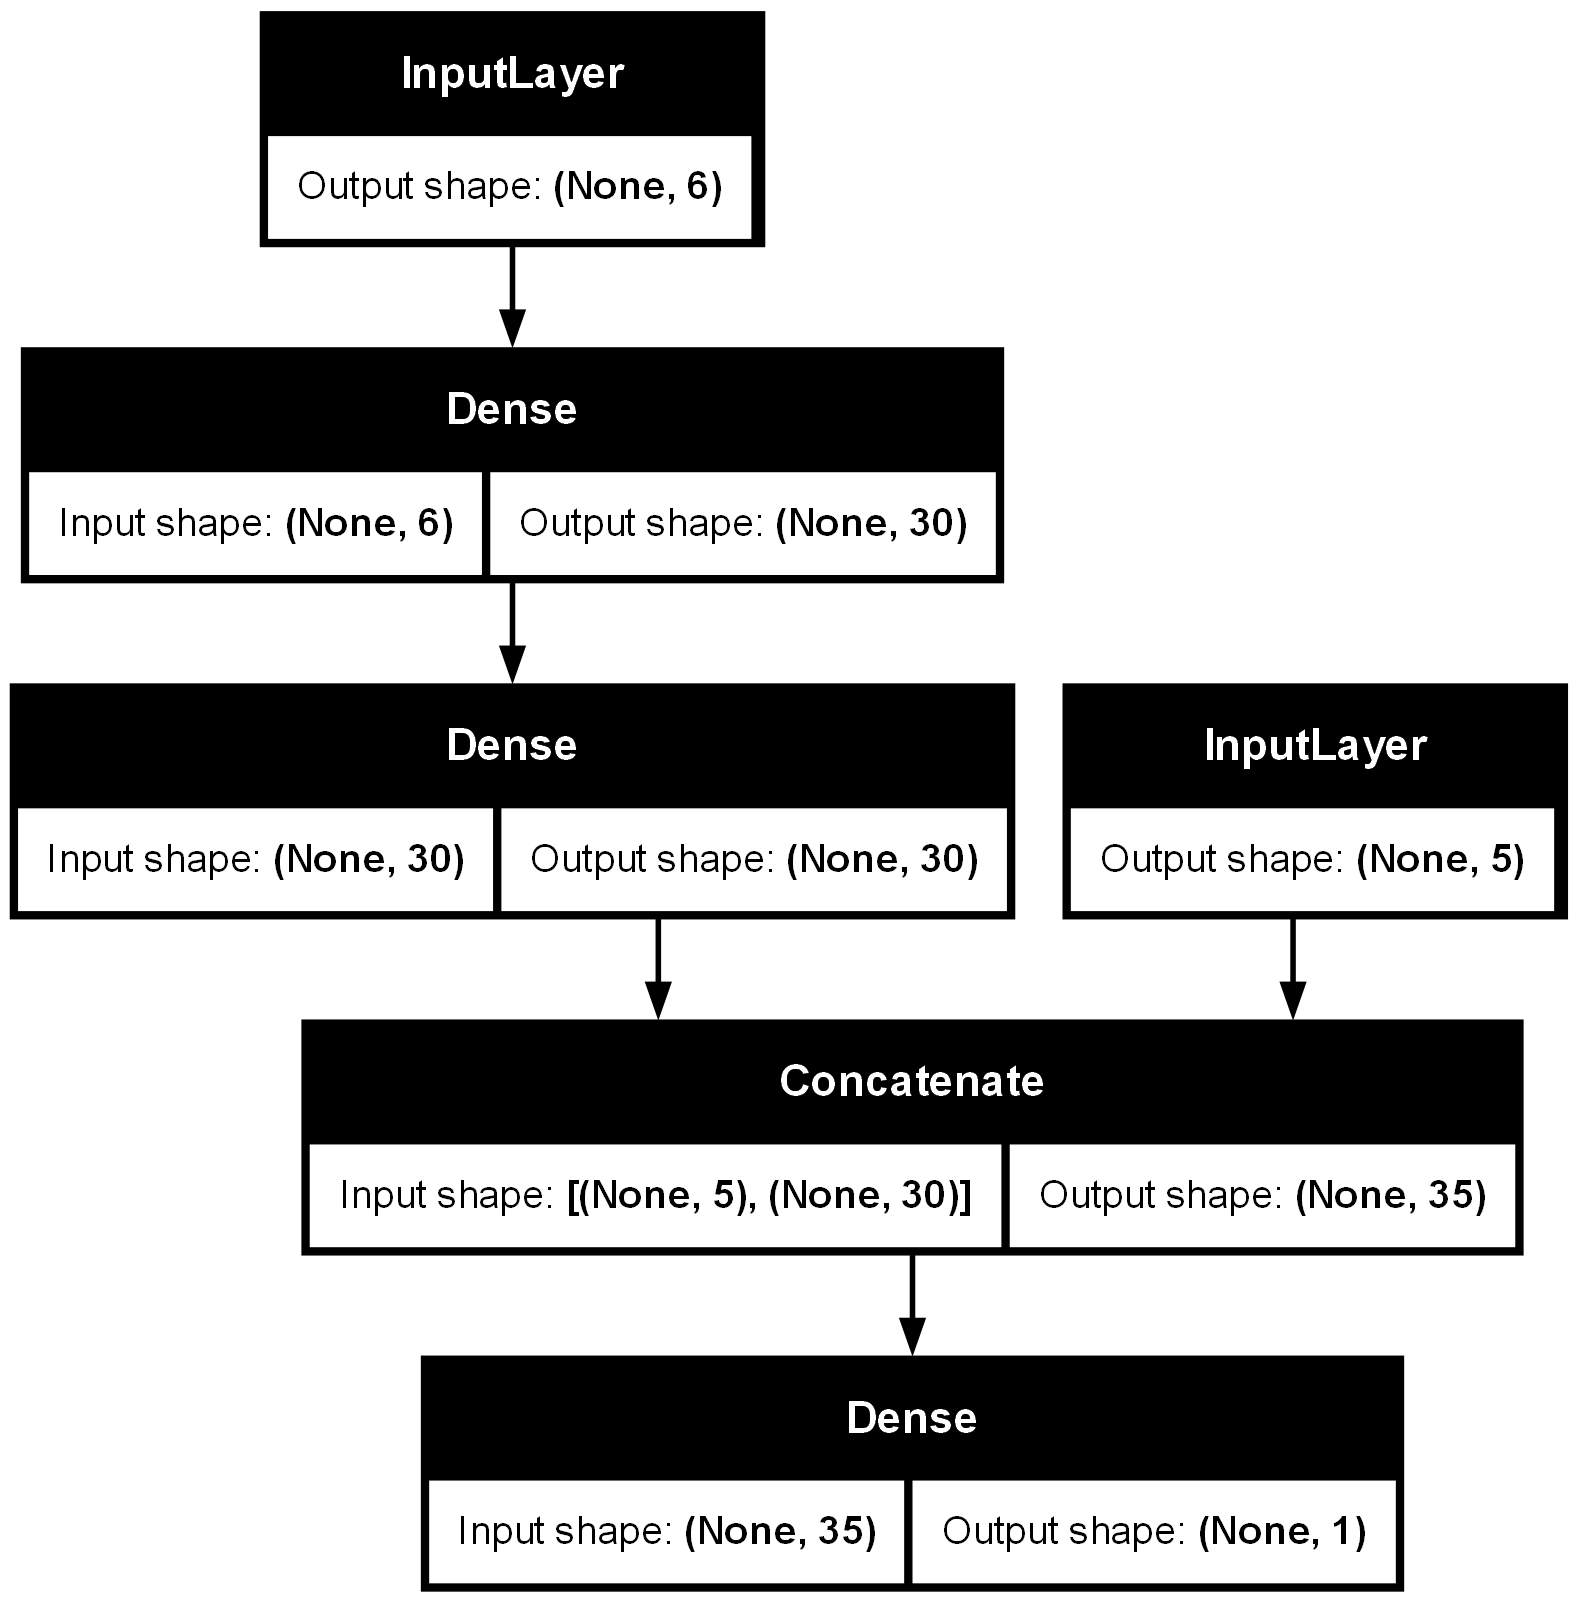

In [42]:
# Splitting the input - for multiple inputs model
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=(5,), name="wide_input")

input_B = keras.layers.Input(shape=(6,), name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)

# define the model by specifying the inputs and output tensors 
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

keras.utils.plot_model(model, show_shapes=True)

In [43]:
X_train.shape

(11610, 8)

In [8]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

# Generate the data - split the features 

# X_train_A - fetaure 0-4 (5)
# X_train_B - feature 2-8 (6)
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

# fit
history = model.fit(x=(X_train_A, X_train_B), 
                    y=y_train, 
                    epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid)
                   )
# evaluate on test
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
# make a prediction
y_pred = model.predict((X_new_A, X_new_B))


Epoch 1/20
 62/363 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 4.9145  

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1842 - val_loss: 2.2747
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8514 - val_loss: 0.6670
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6551 - val_loss: 0.5849
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6058 - val_loss: 0.5364
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 0.5451 - val_loss: 0.5056
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5529 - val_loss: 0.4739
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4817 - val_loss: 0.4556
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4772 - val_loss: 0.4402
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4502 - val_loss: 0.4286
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.4442 - val_loss: 0.4249
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 0.4556 - val_loss: 0.4191
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

## Multi Input Multi output Model <a class="anchor" id="multi_input_output_model"></a>

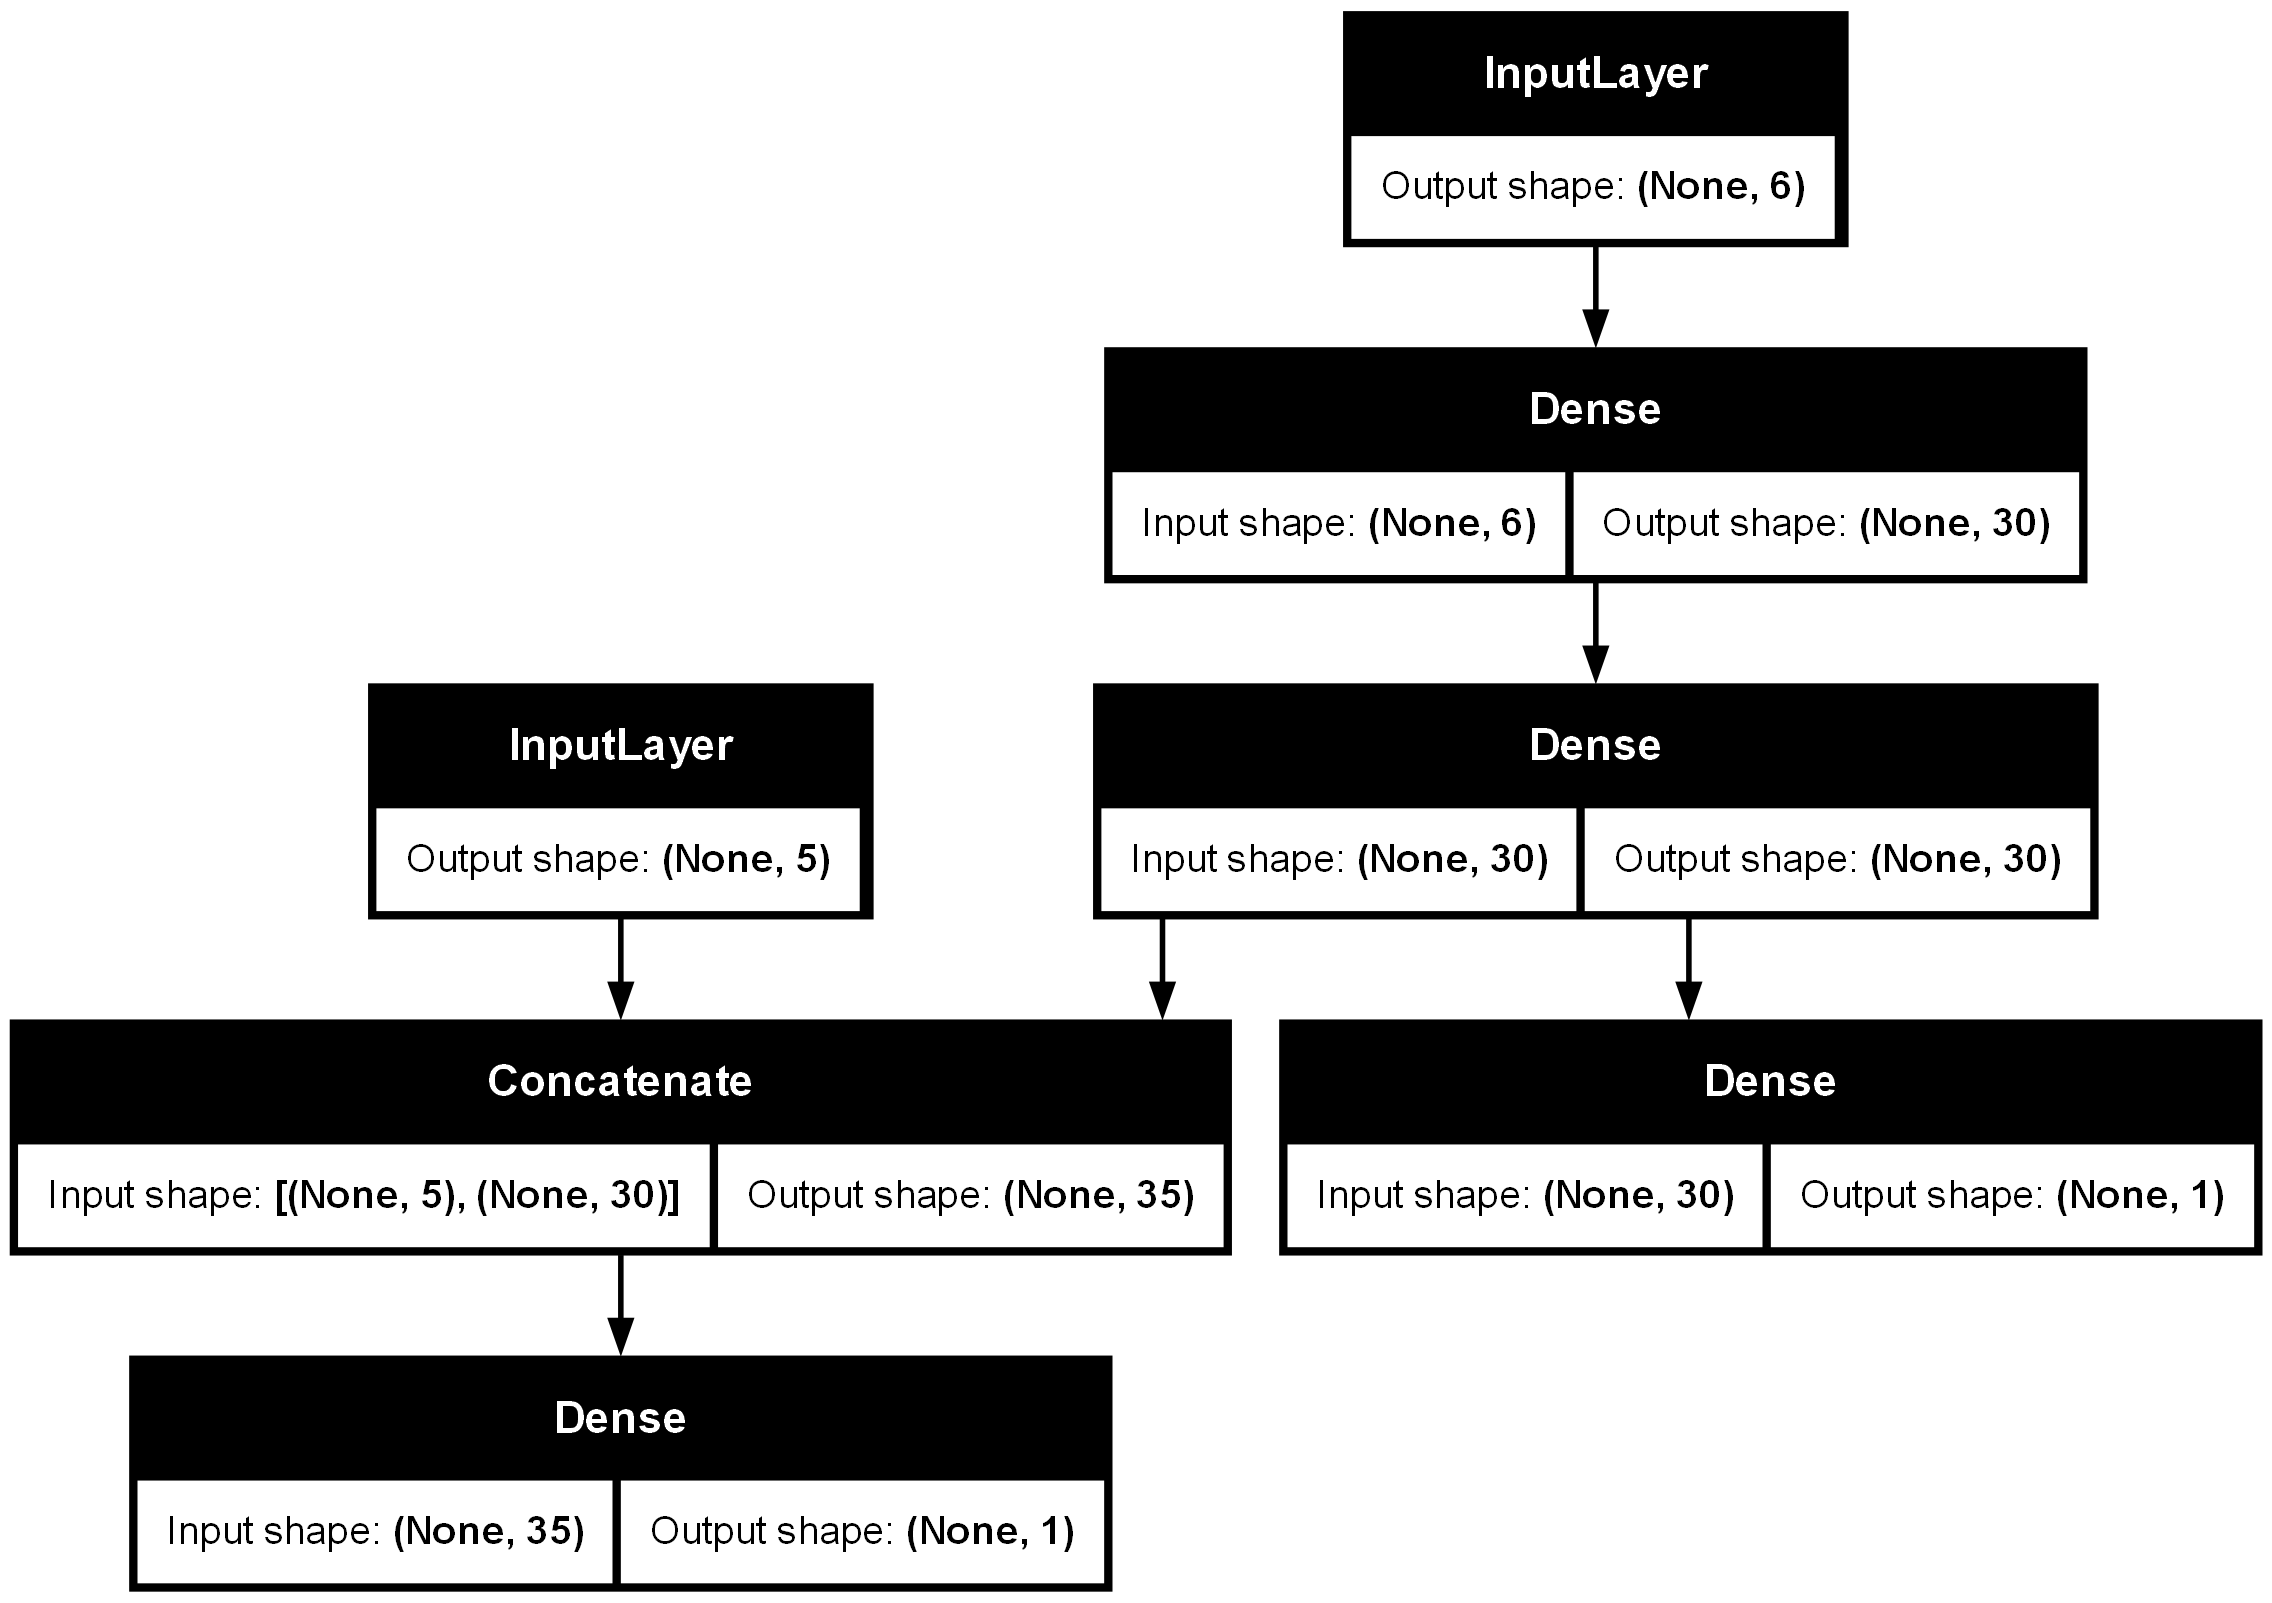

In [9]:
input_A = keras.layers.Input(shape=(5,), name="wide_input")

input_B = keras.layers.Input(shape=(6,), name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)

aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

# for each of the outputs tensors a loss is specified and a weight for aggregating the losses 
model.compile(loss={'main_output': "mse", 'aux_output':"mse"}, 
              loss_weights={'main_output': 0.9, 'aux_output':0.1}, 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics={'main_output': 'mse', 'aux_output': 'mse'})

keras.utils.plot_model(model, show_shapes=True)

In [10]:
history = model.fit(x=[X_train_A, X_train_B], 
                    y=[y_train, y_train], 
                    epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

# we see that the lower the weight the bigger the loss - as it is less influential on the final loss

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - aux_output_mse: 4.7894 - loss: 3.5685 - main_output_mse: 3.4328 - val_aux_output_mse: 3.6055 - val_loss: 1.2356 - val_main_output_mse: 0.9723
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_mse: 2.9627 - loss: 1.0905 - main_output_mse: 0.8825 - val_aux_output_mse: 3.6564 - val_loss: 1.0209 - val_main_output_mse: 0.7281
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_mse: 2.1799 - loss: 0.8489 - main_output_mse: 0.7010 - val_aux_output_mse: 3.7394 - val_loss: 1.0166 - val_main_output_mse: 0.7140
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_mse: 1.7790 - loss: 0.7431 - main_output_mse: 0.6280 - val_aux_output_mse: 3.6310 - val_loss: 0.9835 - val_main_output_mse: 0.6894
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_mse: 1.5974 - loss: 0.6850 - main_output_mse: 0.5837 - val_aux_output_mse: 3.2591 - val_loss: 0.8554 - val_main_output_mse: 0.5884
Epoch 6/20
363/363 ━

In [11]:
total_loss, main_loss, aux_loss = model.evaluate(
    x=[X_test_A, X_test_B], 
    y=[y_test, y_test]
)

print(f'metrics: {model.metrics_names}')

print(f"""
main loss {main_loss}
aux loss {aux_loss}
total loss {total_loss}
""")
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - aux_output_mse: 0.9295 - loss: 0.4688 - main_output_mse: 0.4176
metrics: ['loss', 'compile_metrics']

main loss 0.9358932971954346
aux loss 0.4120461046695709
total loss 0.46443089842796326

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


## The subclassing API <a class="anchor" id="subclass_api"></a>

In [12]:
keras.backend.clear_session()


# define the model as a derived class of Model class
class WideAndDeepModel(keras.models.Model):
    
    def __init__(self, units=30, activation="relu", **kwargs):
    
        super().__init__(**kwargs)
        # all layers are declared in the constructor
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1, name="main_output")
        self.aux_output = keras.layers.Dense(1, name="aux_output")
    
    def call(self, inputs):
        # forward pass 
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

# need to be buit before summary is available
model.build(input_shape=[(None, 5), (None, 6)])
model.summary()

# plot_model does not work out of the box :)
# inputs = [keras.layers.Input(shape=(None,8)),keras.layers.Input(shape=(None,8))]
# model = keras.models.Model(inputs=inputs,outputs=model.call(inputs))
# keras.utils.plot_model(model, show_shapes=True)


C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'wide_and_deep_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "wide_and_deep_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ main_output (Dense)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ aux_output (Dense)                   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(loss=["mse", "mse"], 
              loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["mse", "mse"])

history = model.fit(x=(X_train_A, X_train_B), 
                    y=(y_train, y_train), 
                    epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))

total_loss, main_loss, aux_loss, _ = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))


Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4746 - mse: 0.4291 - mse_1: 0.8838 - val_loss: 0.4839 - val_mse: 0.3964 - val_mse_1: 1.2713
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4557 - mse: 0.4139 - mse_1: 0.8318 - val_loss: 0.4736 - val_mse: 0.3909 - val_mse_1: 1.2172
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4631 - mse: 0.4226 - mse_1: 0.8276 - val_loss: 0.4673 - val_mse: 0.3856 - val_mse_1: 1.2018
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4511 - mse: 0.4110 - mse_1: 0.8117 - val_loss: 0.5149 - val_mse: 0.4332 - val_mse_1: 1.2504
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4644 - mse: 0.4255 - mse_1: 0.8136 - val_loss: 0.4675 - val_mse: 0.4062 - val_mse_1: 1.0192
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4625 - mse: 0.4263 - mse_1: 0.7882 - val_loss: 0.4508 - val_mse: 0.3834 - val_mse_1: 1.0571
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4525 - mse: 0.

## Hyperparameters search using scikit learn API <a class="anchor" id="hyperparam_search"></a>
a wrapper Scikit-Learn API

In [ ]:
# %pip install scikeras

In [19]:
from scikeras.wrappers import KerasRegressor

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


keras_reg = KerasRegressor(build_fn=build_model,
                           n_hidden=1,
                           n_neurons=30,
                           learning_rate=3e-3,
                           input_shape=[8])

# for classifier 
# keras_cls = keras.wrappers.scikit_learn.KerasClassifier(build_model)

keras_reg.fit(X_train, y_train, epochs=10,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

mse_test = keras_reg.score(X_test, y_test)


Epoch 1/10


C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3940 - val_loss: 21.7642
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8078 - val_loss: 43.2307
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8207 - val_loss: 21.1662
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6769 - val_loss: 0.8392
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5658 - val_loss: 0.4941
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5254 - val_loss: 0.4487
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4986 - val_loss: 0.4318
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4799 - val_loss: 0.4234
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4661 - val_loss: 0.4194
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4551 - val_loss: 0.4166
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [20]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

# specify the search domain
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(), # sampling from A loguniform
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X=X_train, y=y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

print(f'''
best params: {rnd_search_cv.best_params_}
best score: {rnd_search_cv.best_score_}
''')

# KerasRegressor
rnd_search_cv.best_estimator_

best_model = model = rnd_search_cv.best_estimator_.model


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100


C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3278 - val_loss: 1.8082
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4656 - val_loss: 1.2221
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.4395 - val_loss: 0.5437
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.4306 - val_loss: 1.0478
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.4312 - val_loss: 0.5269
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.4378 - val_loss: 1.1502
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.4291 - val_loss: 0.5899
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.4323 - val_loss: 1.4682
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.4281 - val_loss: 0.8139
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.4285 - val_loss: 1.7611
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.4360 - val_loss: 0.9756
Epoch 12/100
242/242 ━━━━━━━━━━━━━━

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3442 - val_loss: 0.5167
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5107 - val_loss: 0.4202
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4465 - val_loss: 0.4042
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4355 - val_loss: 0.3979
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4301 - val_loss: 0.3943
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4268 - val_loss: 0.3916
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.4243 - val_loss: 0.3893
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4221 - val_loss: 0.3878
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4200 - val_loss: 0.3865
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4181 - val_loss: 0.3851
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4162 - val_loss: 0.4704
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8711 - val_loss: 0.8255
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.7092 - val_loss: 0.8578
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.7261 - val_loss: 0.4558
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.4644 - val_loss: 0.4026
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.4194 - val_loss: 0.3872
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.4075 - val_loss: 0.3792
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4013 - val_loss: 0.3735
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3969 - val_loss: 0.3691
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.3935 - val_loss: 0.3663
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3911 - val_loss: 0.3640
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.4117 - val_loss: 0.3679
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9235 - val_loss: 10.2552
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5781 - val_loss: 9.2043
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5209 - val_loss: 0.7980
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4367 - val_loss: 0.4056
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4077 - val_loss: 0.3795
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3890 - val_loss: 0.3738
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3760 - val_loss: 0.3695
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3663 - val_loss: 0.3648
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3588 - val_loss: 0.3599
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3529 - val_loss: 0.3549
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3482 - val_loss: 0.3521
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7864 - val_loss: 0.8798
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5310 - val_loss: 0.4446
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4479 - val_loss: 0.4250
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4111 - val_loss: 0.3716
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3926 - val_loss: 0.3788
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3815 - val_loss: 0.4269
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3738 - val_loss: 0.4820
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3679 - val_loss: 0.5380
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3633 - val_loss: 0.5767
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3595 - val_loss: 0.6014
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3563 - val_loss: 0.6044
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7859 - val_loss: 3.5963
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5406 - val_loss: 0.9058
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4552 - val_loss: 0.4012
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4150 - val_loss: 0.3881
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3956 - val_loss: 0.3750
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3835 - val_loss: 0.3665
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3743 - val_loss: 0.3587
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3671 - val_loss: 0.3529
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3610 - val_loss: 0.3457
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3557 - val_loss: 0.3382
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3513 - val_loss: 0.3398
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.3073 - val_loss: 4.2578
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 1.5811 - val_loss: 3.0756
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 1.0493 - val_loss: 1.9926
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8672 - val_loss: 1.3351
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7927 - val_loss: 0.9967
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7543 - val_loss: 0.8382
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7294 - val_loss: 0.7536
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7104 - val_loss: 0.7068
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6946 - val_loss: 0.6794
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6805 - val_loss: 0.6613
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6677 - val_loss: 0.6470
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0733 - val_loss: 3.2296
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5561 - val_loss: 1.4255
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 1.3977 - val_loss: 1.0001
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.9899 - val_loss: 0.8440
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.8288 - val_loss: 0.7477
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.7531 - val_loss: 0.6857
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7107 - val_loss: 0.6536
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.6827 - val_loss: 0.6464
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6619 - val_loss: 0.6588
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6449 - val_loss: 0.6861
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6302 - val_loss: 0.7252
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3483 - val_loss: 9.9445
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 2.3415 - val_loss: 5.3634
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 1.4899 - val_loss: 2.7848
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0996 - val_loss: 1.5697
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9163 - val_loss: 1.0708
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8254 - val_loss: 0.8578
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7750 - val_loss: 0.7643
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7431 - val_loss: 0.7180
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.7202 - val_loss: 0.6911
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.7022 - val_loss: 0.6727
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6872 - val_loss: 0.6584
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1869 - val_loss: 3.1620
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7993 - val_loss: 0.8592
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6459 - val_loss: 0.5814
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5877 - val_loss: 0.5441
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5462 - val_loss: 0.5076
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5137 - val_loss: 0.4796
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4880 - val_loss: 0.4570
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4677 - val_loss: 0.4405
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4516 - val_loss: 0.4270
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4387 - val_loss: 0.4161
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4281 - val_loss: 0.4073
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7871 - val_loss: 22.0626
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7822 - val_loss: 9.1676
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6687 - val_loss: 3.7159
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6003 - val_loss: 1.8500
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5473 - val_loss: 0.9514
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5079 - val_loss: 0.5749
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4798 - val_loss: 0.4497
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4594 - val_loss: 0.4194
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4444 - val_loss: 0.4148
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4329 - val_loss: 0.4100
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4238 - val_loss: 0.4002
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.2937 - val_loss: 17.0301
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7624 - val_loss: 1.0651
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6182 - val_loss: 0.5606
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5600 - val_loss: 0.5070
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5219 - val_loss: 0.4759
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4924 - val_loss: 0.4528
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4693 - val_loss: 0.4350
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4511 - val_loss: 0.4216
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4370 - val_loss: 0.4119
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4261 - val_loss: 0.4054
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4173 - val_loss: 0.4013
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7783 - val_loss: 174.6936
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.8566 - val_loss: 54.8700
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.7807 - val_loss: 1241.1039
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5366 - val_loss: 2939.3286
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 6.3412 - val_loss: 17690.9160
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 31.3438 - val_loss: 67153.4219
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 123.6227 - val_loss: 316028.0938
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 564.9077 - val_loss: 1340925.1250
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 2424.1233 - val_loss: 5976650.5000
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 10740.0693 - val_loss: 26018420.0000
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 46882.51

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2469 - val_loss: 6.5452
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.5730 - val_loss: 13.9577
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.5226 - val_loss: 14.8207
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.5101 - val_loss: 14.6898
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.5066 - val_loss: 14.5628
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.5054 - val_loss: 14.5108
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.5049 - val_loss: 14.5013
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.5047 - val_loss: 14.5092
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.5046 - val_loss: 14.5220
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.5045 - val_loss: 14.5345
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.5045 - val_loss: 14.5449
Epoch 12/100
242/242 ━━

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6866 - val_loss: 300.9292
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.1563 - val_loss: 5.0663
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.6833 - val_loss: 228.6787
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.9860 - val_loss: 11.3881
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 0.6613 - val_loss: 188.4984
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.9129 - val_loss: 19.8376
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.6643 - val_loss: 161.3562
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.8686 - val_loss: 28.6145
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.6738 - val_loss: 141.6453
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.8382 - val_loss: 36.7999
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.6848 - val_loss: 126.9421
Epoch 12/100
242/

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7904 - val_loss: 0.8896
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6434 - val_loss: 0.5889
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5395 - val_loss: 0.4676
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4720 - val_loss: 0.4364
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4295 - val_loss: 0.3932
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4021 - val_loss: 0.3794
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3845 - val_loss: 0.3668
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3736 - val_loss: 0.3609
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3656 - val_loss: 0.3546
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3593 - val_loss: 0.3517
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3540 - val_loss: 0.3479
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0581 - val_loss: 1.1540
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6460 - val_loss: 0.5767
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5695 - val_loss: 0.7872
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5163 - val_loss: 0.8693
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4738 - val_loss: 0.9104
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4400 - val_loss: 0.7725
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4151 - val_loss: 0.6465
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3962 - val_loss: 0.4848
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3816 - val_loss: 0.4148
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3711 - val_loss: 0.3549
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3630 - val_loss: 0.3417
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7595 - val_loss: 0.8551
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5108 - val_loss: 1.4167
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4577 - val_loss: 1.1287
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4301 - val_loss: 1.6124
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4105 - val_loss: 1.1873
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4048 - val_loss: 0.3715
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3914 - val_loss: 0.3757
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3839 - val_loss: 0.3804
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3780 - val_loss: 0.3761
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3732 - val_loss: 0.3625
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3697 - val_loss: 0.3569
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6384 - val_loss: 2.4856
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7604 - val_loss: 0.8936
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6514 - val_loss: 0.5958
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 0.5919 - val_loss: 0.5433
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 0.5478 - val_loss: 0.5045
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.5141 - val_loss: 0.4768
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.4890 - val_loss: 0.4561
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.4702 - val_loss: 0.4407
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4560 - val_loss: 0.4292
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.4451 - val_loss: 0.4201
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 0.4365 - val_loss: 0.4129
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9836 - val_loss: 7.2103
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.7891 - val_loss: 1.9423
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.6799 - val_loss: 0.6430
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.6215 - val_loss: 0.7725
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.5785 - val_loss: 1.3103
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.5455 - val_loss: 1.8288
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5196 - val_loss: 2.1746
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.4990 - val_loss: 2.3258
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 0.4824 - val_loss: 2.3167
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.4691 - val_loss: 2.1942
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4583 - val_loss: 2.0050
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9762 - val_loss: 2.0955
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.6342 - val_loss: 1.5164
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5887 - val_loss: 0.5436
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5459 - val_loss: 0.6143
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5178 - val_loss: 0.4821
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4932 - val_loss: 0.4849
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.4746 - val_loss: 0.4493
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.4598 - val_loss: 0.4382
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.4482 - val_loss: 0.4235
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4389 - val_loss: 0.4142
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4315 - val_loss: 0.4061
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7580 - val_loss: 4.2372
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5154 - val_loss: 39.8320
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5726 - val_loss: 2.9238
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4436 - val_loss: 0.4747
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3879 - val_loss: 0.3955
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3710 - val_loss: 0.3793
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3597 - val_loss: 0.3704
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3517 - val_loss: 0.3639
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3452 - val_loss: 0.3596
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3401 - val_loss: 0.3562
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3357 - val_loss: 0.3538
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9335 - val_loss: 0.5403
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5263 - val_loss: 1.0673
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4418 - val_loss: 0.8568
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4051 - val_loss: 0.5637
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3850 - val_loss: 0.4083
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3722 - val_loss: 0.3456
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3636 - val_loss: 0.3396
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3573 - val_loss: 0.3537
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3524 - val_loss: 0.3717
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3481 - val_loss: 0.3917
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3444 - val_loss: 0.4090
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6106 - val_loss: 0.7205
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5226 - val_loss: 1.0798
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4398 - val_loss: 4.0365
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4179 - val_loss: 4.4277
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3890 - val_loss: 1.4210
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3852 - val_loss: 0.5808
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3661 - val_loss: 0.3427
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3581 - val_loss: 0.3490
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3503 - val_loss: 0.3361
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3450 - val_loss: 0.3304
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3402 - val_loss: 0.3314
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9208 - val_loss: 6.8771
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5493 - val_loss: 9.2126
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4758 - val_loss: 1.0047
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4163 - val_loss: 0.4434
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3857 - val_loss: 0.3657
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3688 - val_loss: 0.3451
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3575 - val_loss: 0.3515
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3496 - val_loss: 0.3487
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3435 - val_loss: 0.3422
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3385 - val_loss: 0.3379
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3343 - val_loss: 0.3335
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6318 - val_loss: 0.5226
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4887 - val_loss: 0.4319
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4203 - val_loss: 0.3872
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3915 - val_loss: 0.5569
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3760 - val_loss: 0.7613
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3655 - val_loss: 0.8722
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3573 - val_loss: 0.8964
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3516 - val_loss: 0.8823
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3467 - val_loss: 0.8604
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3427 - val_loss: 0.8671
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3395 - val_loss: 0.8690
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6950 - val_loss: 6.9319
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5739 - val_loss: 2.2510
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4508 - val_loss: 0.4088
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4056 - val_loss: 0.3874
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3840 - val_loss: 0.3812
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3720 - val_loss: 0.3718
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3628 - val_loss: 0.3643
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3556 - val_loss: 0.3573
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3499 - val_loss: 0.3497
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3451 - val_loss: 0.3436
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3411 - val_loss: 0.3416
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6265 - val_loss: 10.5862
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6054 - val_loss: 10.2621
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5377 - val_loss: 0.8338
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4507 - val_loss: 0.4407
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4190 - val_loss: 0.3853
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4006 - val_loss: 0.3811
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3886 - val_loss: 0.3874
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3803 - val_loss: 0.3889
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3738 - val_loss: 0.3875
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3684 - val_loss: 0.3852
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3636 - val_loss: 0.3815
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5487 - val_loss: 1.0802
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6091 - val_loss: 0.5400
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4986 - val_loss: 0.4358
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4428 - val_loss: 0.4161
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4158 - val_loss: 0.4508
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4007 - val_loss: 0.5391
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3908 - val_loss: 0.6541
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3833 - val_loss: 0.7563
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3775 - val_loss: 0.8446
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3727 - val_loss: 0.9231
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3687 - val_loss: 0.9843
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9572 - val_loss: 6.4484
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5469 - val_loss: 11.5453
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4901 - val_loss: 1.8830
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4374 - val_loss: 0.4029
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4090 - val_loss: 0.3793
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3943 - val_loss: 0.3851
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3835 - val_loss: 0.3877
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3755 - val_loss: 0.3845
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3695 - val_loss: 0.3804
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3645 - val_loss: 0.3689
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3604 - val_loss: 0.3667
Epoch 12/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2565 - val_loss: 1.0772
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4613 - val_loss: 1.3681
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4100 - val_loss: 2.0442
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3939 - val_loss: 0.4557
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3725 - val_loss: 0.3388
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3634 - val_loss: 0.3684
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3566 - val_loss: 0.3307
Epoch 8/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3511 - val_loss: 0.3639
Epoch 9/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3462 - val_loss: 0.3314
Epoch 10/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.3424 - val_loss: 0.3721
Epoch 11/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3382 - val_loss: 0.3161
Epoch 12/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

In [29]:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# standardizing per pixel 
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

## Batch Normalization <a class="anchor" id="batch_normalization"></a>

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=10, activation="softmax")
])
model.summary()


# Using before activations - note that now we define the activation outside 
# of the layer definition we also don't use bias, since it is learned by the bias
# parameter of the BN layer

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(300, use_bias=False),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation("relu"),
#     keras.layers.Dense(100, use_bias=False),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation("relu"),
#     keras.layers.Dense(10, activation="softmax")
# ])

C:\Users\Or\Desktop\Applied Machine Learning\Notebooks\myenv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 784)                 │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [23]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]


[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

In [24]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6020 - loss: 1.2124 - val_accuracy: 0.8090 - val_loss: 0.5737
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7926 - loss: 0.6067 - val_accuracy: 0.8366 - val_loss: 0.4928
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8200 - loss: 0.5304 - val_accuracy: 0.8516 - val_loss: 0.4555
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8335 - loss: 0.4896 - val_accuracy: 0.8578 - val_loss: 0.4326
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8417 - loss: 0.4620 - val_accuracy: 0.8622 - val_loss: 0.4169
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8484 - loss: 0.4409 - val_accuracy: 0.8650 - val_loss: 0.4050
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8541 - loss: 0.4238 - val_accuracy: 0.8698 - val_loss: 0.3957
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8592 - loss: 0.4093 - 

## Gradient clipping  <a class="anchor" id="grad_clipping"></a>

In [25]:
# clips the gradients by a specified maximum absolute value. 
# If any component of the gradient exceeds this value, it will be set to this maximum value.
optimizer = keras.optimizers.SGD(clipvalue=1.0)

# used to clip the gradients to have a maximum L2 norm (Euclidean norm). 
# This means that if the norm of the gradients exceeds the specified value, 
# it will be scaled down so that the norm is equal to the specified value.
optimizer = keras.optimizers.SGD(clipnorm=1.0)


## Transfer learning  <a class="anchor" id="transfer_learning"></a>

In [29]:

model_A = keras.models.load_model("my_model.keras")

# if we won't clone model A, its weights will be updated with modelB_on_A
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))
                 
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# You must always compile your model after you freeze or unfreeze layers.
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])